# Euclidean Capacitated K-Center (CORRECTED)


## 1. Setup and Installation

In [ ]:
# Install required packages
!pip install networkx scikit-learn matplotlib seaborn pandas numpy -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import warnings
import time
from itertools import combinations_with_replacement
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All packages installed successfully")
print(f"  NetworkX version: {nx.__version__}")
print(f"  NumPy version: {np.__version__}")

✓ All packages installed successfully
  NetworkX version: 3.5
  NumPy version: 2.0.2


## 2. Data Loading

In [ ]:
# Upload the CSV file
from google.colab import files
print("Please upload your india_states_capitals.csv file:")
uploaded = files.upload()

Please upload your india_states_capitals.csv file:


Saving india_states_capitals.csv to india_states_capitals.csv


In [ ]:
# Load the data
df = pd.read_csv("india_states_capitals.csv")
print("="*70)
print("DATA LOADED")
print("="*70)
print(f"Total state capitals: {len(df)}")
print(f"\nFirst 5 rows:")
display(df.head())

# Prepare coordinate matrices
C = df[["Latitude", "Longitude"]].values
F = C.copy()

n_clients = len(C)
print(f"\n→ Total clients: {n_clients}")
print(f"→ Potential facility locations: {len(F)}")

DATA LOADED
Total state capitals: 28

First 5 rows:


,State,Capital,Latitude,Longitude
0,Andhra Pradesh,Amaravati,16.5730,80.3575
1,Arunachal Pradesh,Itanagar,27.0844,93.6053
2,Assam,Dispur,26.1445,91.7362
3,Bihar,Patna,25.5941,85.1376
4,Chhattisgarh,Raipur,21.2514,81.6296



→ Total clients: 28
→ Potential facility locations: 28


## 3. Distance Computation

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate great circle distance in kilometers"""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

def compute_distance_matrix(points1, points2=None):
    """Compute pairwise distances using Haversine"""
    if points2 is None:
        points2 = points1

    n1, n2 = len(points1), len(points2)
    distances = np.zeros((n1, n2))

    for i in range(n1):
        for j in range(n2):
            distances[i, j] = haversine_distance(
                points1[i, 0], points1[i, 1],
                points2[j, 0], points2[j, 1]
            )

    return distances

print("✓ Distance functions ready")

print("\nComputing distance matrices...")
dist_CC = compute_distance_matrix(C, C)
dist_CF = compute_distance_matrix(C, F)
dist_FF = compute_distance_matrix(F, F)
print(f"✓ Distance matrices computed")

✓ Distance functions ready

Computing distance matrices...
✓ Distance matrices computed


## 4. Basic K-Center (For Initial Clustering)



In [ ]:
def basic_k_center_deterministic(X, k, distance_matrix=None):
    """
    Basic K-Center using greedy farthest-first traversal
    DETERMINISTIC: Starts from point farthest from centroid

    Gives 2-approximation for k-center problem
    """
    n = len(X)

    if distance_matrix is None:
        distance_matrix = compute_distance_matrix(X)

    centroid = X.mean(axis=0)
    dist_to_centroid = np.array([haversine_distance(
        X[i,0], X[i,1], centroid[0], centroid[1]
    ) for i in range(n)])

    centers = [np.argmax(dist_to_centroid)]

    for _ in range(k - 1):
        min_dists = distance_matrix[:, centers].min(axis=1)
        next_center = np.argmax(min_dists)
        centers.append(next_center)

    return centers

print("✓ Basic K-Center function ready (deterministic)")

✓ Basic K-Center function ready (deterministic)


## 5. Initial Clustering


In [ ]:
def compute_initial_clustering(C, F, k, distance_matrix=None):
    """
    Step 1 of Algorithm 1: Find (1+ε)-approximate clustering

    CORRECTED: Uses basic k-center (gives 2-approximation)
    NOT K-Means (which doesn't give k-center approximation)

    Returns:
        S_prime: Initial facility locations
        centers_idx: Indices of initial centers
        r_prime: Radius of initial clustering
    """
    centers_idx = basic_k_center_deterministic(C, k, distance_matrix)
    S_prime = C[centers_idx]

    distances = compute_distance_matrix(C, S_prime)
    min_distances = distances.min(axis=1)
    r_prime = min_distances.max()

    return S_prime, centers_idx, r_prime

print("✓ Initial clustering function ready (using k-center)")

✓ Initial clustering function ready (using k-center)


## 6. Partition Generation (NEW!)

#Generate all partitions of k into r parts

In [ ]:
def generate_partitions(k, r):
    """
    Generate all partitions of k into r non-negative integer parts

    Example: k=5, r=3
    Yields: (5,0,0), (4,1,0), (4,0,1), (3,2,0), (3,1,1), (3,0,2), ...

    Total: C(k+r-1, r-1) partitions (stars and bars)
    For k=5, r=5: C(9,4) = 126 partitions
    """
    if r == 1:
        yield (k,)
        return

    for i in range(k + 1):
        for rest in generate_partitions(k - i, r - 1):
            yield (i,) + rest

print("Testing partition generation:")
test_partitions = list(generate_partitions(5, 3))
print(f"  Partitions of k=5 into r=3 parts: {len(test_partitions)}")
print(f"  First 5: {test_partitions[:5]}")
print(f"  Expected: C(5+3-1, 3-1) = C(7,2) = 21")

k_test, r_test = 5, 5
count = len(list(generate_partitions(k_test, r_test)))
print(f"\nFor k={k_test}, r={r_test}: {count} partitions")
print(f"  Expected: C({k_test+r_test-1}, {r_test-1}) = C(9,4) = 126")
print("\n✓ Partition generation working correctly!")

Testing partition generation:
  Partitions of k=5 into r=3 parts: 21
  First 5: [(0, 0, 5), (0, 1, 4), (0, 2, 3), (0, 3, 2), (0, 4, 1)]
  Expected: C(5+3-1, 3-1) = C(7,2) = 21

For k=5, r=5: 126 partitions
  Expected: C(9, 4) = C(9,4) = 126

✓ Partition generation working correctly!


## 7. Max-Flow Network Construction (With Partitions)

In [ ]:
def build_flow_network_with_partition(C, F, S_prime, partition, capacity, r, r_prime, dist_CF, dist_FF):
    """
    Build max-flow network for specific partition

    Parameters:
        C: Client locations
        F: All potential facility locations
        S_prime: Initial r facilities from Step 1
        partition: Tuple (k1, k2, ..., kr) where sum = k
                  k_i = number of facilities to open near S_prime[i]
        capacity: Maximum clients per facility (U)
        r: Current radius being tested
        r_prime: Radius from initial clustering
        dist_CF: Distance matrix clients to all facilities
        dist_FF: Distance matrix between all facilities

    Returns:
        G: NetworkX DiGraph
        client_nodes: List of client node names
        facility_nodes: List of facility node names
        facility_mapping: Dict mapping facility nodes to actual facility indices
    """
    n_clients = len(C)
    r_facilities = len(S_prime)

    G = nx.DiGraph()

    # Add source and sink
    source = 'source'
    sink = 'sink'
    G.add_node(source)
    G.add_node(sink)

    # Add client nodes
    client_nodes = [f'c_{i}' for i in range(n_clients)]
    G.add_nodes_from(client_nodes)

    # Edge: Source to each client (capacity 1)
    for client_node in client_nodes:
        G.add_edge(source, client_node, capacity=1)

    # For each initial facility f'_i in S_prime:
    facility_nodes = []
    facility_mapping = {}  # Maps facility node name to actual facility index
    facility_counter = 0

    for i, f_prime in enumerate(S_prime):
        k_i = partition[i]  # Number of facilities to open near f'_i

        if k_i == 0:
            continue

        # Find clients within r+r' from f'_i
        dist_to_f_prime = compute_distance_matrix(C, f_prime.reshape(1, -1)).flatten()
        eligible_clients = np.where(dist_to_f_prime <= r + r_prime)[0]

        # Find facilities within r' from f'_i
        dist_f_to_f_prime = compute_distance_matrix(F, f_prime.reshape(1, -1)).flatten()
        eligible_facilities_idx = np.where(dist_f_to_f_prime <= r_prime)[0]

        # Sort by distance and take k_i closest facilities
        sorted_facilities = eligible_facilities_idx[np.argsort(dist_f_to_f_prime[eligible_facilities_idx])]
        selected_facilities = sorted_facilities[:k_i]

        # Create k_i facility nodes for this group
        for f_idx in selected_facilities:
            facility_node = f'f_{facility_counter}'
            facility_nodes.append(facility_node)
            facility_mapping[facility_node] = f_idx

            # Edge: Facility to sink (capacity U)
            G.add_edge(facility_node, sink, capacity=capacity)

            # Edges: Client to facility (if d(c,f) ≤ r+r')
            for c_idx in eligible_clients:
                if dist_CF[c_idx, f_idx] <= r + r_prime:
                    G.add_edge(client_nodes[c_idx], facility_node, capacity=1)

            facility_counter += 1

    return G, client_nodes, facility_nodes, facility_mapping

print("✓ Max-flow network builder ready (with partitions)")

✓ Max-flow network builder ready (with partitions)


## 8. Main Algorithm)



In [ ]:
def euclidean_capacitated_k_center_full(C, F, k, capacity, max_radii=None, verbose=True):
    """
    CORRECTED: Full Algorithm 1 with partition loop

    Parameters:
        C: Client locations (n × 2)
        F: Facility locations (n × 2)
        k: Number of facilities to open
        capacity: Capacity U per facility
        max_radii: Max radii to test (None = test all)
        verbose: Print progress

    Returns:
        best_solution: Dict with facilities, assignments, radius, etc.
    """
    n = len(C)
    start_time = time.time()

    if verbose:
        print("\n" + "="*70)
        print("EUCLIDEAN CAPACITATED K-CENTER (CORRECTED)")
        print("="*70)
        print(f"Clients: {n} | k facilities: {k} | Capacity U: {capacity}")
        print("="*70)

    # Step 1: Initial clustering using BASIC K-CENTER (not K-Means!)
    if verbose:
        print("\n[Step 1/5] Computing initial clustering (k-center)...")

    S_prime, centers_idx, r_prime = compute_initial_clustering(C, F, k, dist_CC)
    r = len(S_prime)  # Number of initial facilities

    if verbose:
        print(f"  → Initial facilities |S'|: {r}")
        print(f"  → Initial radius r': {r_prime:.3f} km")
        print(f"  → Centers: {[df.iloc[i]['Capital'] for i in centers_idx]}")

    # Step 2: Build distance set R
    if verbose:
        print("\n[Step 2/5] Building distance set R...")

    all_distances = dist_CF.flatten()
    R = np.unique(all_distances)
    R = R[R > 0]
    R = np.sort(R)

    if max_radii and len(R) > max_radii:
        percentiles = np.linspace(0, 100, max_radii)
        R_test = np.percentile(R, percentiles)
        R_test = np.unique(R_test)
        if verbose:
            print(f"  → Total unique distances: {len(R)} (sampling {len(R_test)})")
    else:
        R_test = R
        if verbose:
            print(f"  → Total unique distances: {len(R)} (testing all)")

    # Step 3: Generate all partitions
    if verbose:
        print("\n[Step 3/5] Generating partitions...")

    partitions = list(generate_partitions(k, r))

    if verbose:
        print(f"  → Total partitions: {len(partitions)}")
        print(f"  → First 5 partitions: {partitions[:5]}")
        print(f"  → Total iterations: {len(partitions)} × {len(R_test)} = {len(partitions) * len(R_test)}")

    # Step 4: Search over partitions and radii
    if verbose:
        print("\n[Step 4/5] Searching over partitions and radii...")

    best_solution = None
    best_radius = float('inf')

    iterations = 0
    feasible_count = 0

    for p_idx, partition in enumerate(partitions, 1):
        # Skip partitions where one group gets all k facilities (degenerates to single center)
        if max(partition) == k:
            continue

        for r_idx, radius in enumerate(R_test):
            iterations += 1

            try:
                # Build max-flow network for this partition and radius
                G, client_nodes, facility_nodes, facility_mapping = build_flow_network_with_partition(
                    C, F, S_prime, partition, capacity, radius, r_prime, dist_CF, dist_FF
                )

                # Run max-flow
                flow_value, flow_dict = nx.maximum_flow(G, 'source', 'sink')

                # Check if all clients assigned
                if flow_value >= n:
                    # Extract assignments
                    assignments = {}
                    used_facilities = set()

                    for c_idx, client_node in enumerate(client_nodes):
                        if client_node in flow_dict:
                            for facility_node, flow in flow_dict[client_node].items():
                                if flow > 0 and facility_node.startswith('f_'):
                                    actual_f_idx = facility_mapping[facility_node]
                                    assignments[c_idx] = actual_f_idx
                                    used_facilities.add(actual_f_idx)
                                    break

                    # Check facility count
                    if len(used_facilities) <= k:
                        feasible_count += 1

                        if verbose and (feasible_count <= 5 or radius < best_radius):
                            print(f"  Partition {p_idx}/{len(partitions)} {partition}, " +
                                  f"r={radius:.1f}km → FEASIBLE " +
                                  f"(facilities={len(used_facilities)})")

                        # Update best solution
                        if radius < best_radius:
                            best_radius = radius
                            best_solution = {
                                'facilities_indices': list(used_facilities),
                                'facilities': F[list(used_facilities)],
                                'assignments': assignments,
                                'radius': radius,
                                'partition': partition,
                                'flow_value': flow_value,
                                'capacity': capacity,
                                'n_facilities_used': len(used_facilities)
                            }

                            if verbose:
                                print(f"    ★ NEW BEST: r={radius:.3f}km")

            except Exception as e:
                # Network construction or max-flow failed
                pass

            # Progress update every 1000 iterations
            if verbose and iterations % 1000 == 0:
                elapsed = time.time() - start_time
                print(f"  Progress: {iterations}/{len(partitions)*len(R_test)} " +
                      f"({100*iterations/(len(partitions)*len(R_test)):.1f}%), " +
                      f"Time: {elapsed:.1f}s")

    # Step 5: Return best solution
    elapsed = time.time() - start_time

    if verbose:
        print(f"\n[Step 5/5] Optimization complete")
        print(f"  → Total iterations: {iterations}")
        print(f"  → Feasible solutions found: {feasible_count}")
        print(f"  → Time elapsed: {elapsed:.1f}s")

        if best_solution:
            print(f"\n  ✓ BEST SOLUTION:")
            print(f"    Radius: {best_radius:.3f} km")
            print(f"    Partition: {best_solution['partition']}")
            print(f"    Facilities used: {best_solution['n_facilities_used']}/{k}")
            print(f"    All {n} clients assigned")
        else:
            print(f"\n  ✗ No feasible solution found")

        print("="*70 + "\n")

    return best_solution

print("✓ Main algorithm ready (fully corrected with partition loop)")

✓ Main algorithm ready (fully corrected with partition loop)


## 9. Run the Corrected Algorithm

### Configure parameters and run

In [ ]:
# ========== CONFIGURATION ==========
k = 5           # Number of facilities
capacity = 8    # Capacity per facility
max_radii = 30  # Test 30 radii
# ===================================

print(f"Configuration:")
print(f"  → Total clients: {n_clients}")
print(f"  → Facilities (k): {k}")
print(f"  → Capacity (U): {capacity}")
print(f"  → Max radii to test: {max_radii if max_radii else 'all'}")

# Run the fully corrected algorithm
solution_corrected = euclidean_capacitated_k_center_full(
    C, F, k, capacity,
    max_radii=max_radii,
    verbose=True
)

Configuration:
  → Total clients: 28
  → Facilities (k): 5
  → Capacity (U): 8
  → Max radii to test: 30

EUCLIDEAN CAPACITATED K-CENTER (CORRECTED)
Clients: 28 | k facilities: 5 | Capacity U: 8

[Step 1/5] Computing initial clustering (k-center)...
  → Initial facilities |S'|: 5
  → Initial radius r': 709.788 km
  → Centers: ['Thiruvananthapuram', 'Itanagar', 'Jaipur', 'Bhubaneswar', 'Mumbai']

[Step 2/5] Building distance set R...
  → Total unique distances: 351 (sampling 30)

[Step 3/5] Generating partitions...
  → Total partitions: 126
  → First 5 partitions: [(0, 0, 0, 0, 5), (0, 0, 0, 1, 4), (0, 0, 0, 2, 3), (0, 0, 0, 3, 2), (0, 0, 0, 4, 1)]
  → Total iterations: 126 × 30 = 3780

[Step 4/5] Searching over partitions and radii...
  Partition 2/126 (0, 0, 0, 1, 4), r=965.2km → FEASIBLE (facilities=4)
    ★ NEW BEST: r=965.190km
  Partition 2/126 (0, 0, 0, 1, 4), r=1036.4km → FEASIBLE (facilities=4)
  Partition 2/126 (0, 0, 0, 1, 4), r=1095.0km → FEASIBLE (facilities=4)
  Partition 

## 10. Validation Tests

### Verify solution correctness

In [ ]:
if solution_corrected:
    print("\n" + "="*70)
    print("VALIDATION TESTS")
    print("="*70)

    # Test 1: All clients assigned
    test1 = len(solution_corrected['assignments']) == n_clients
    print(f"✓ Test 1: All clients assigned: {test1}")
    print(f"  Assigned: {len(solution_corrected['assignments'])}/{n_clients}")

    # Test 2: Capacity constraints
    facility_loads = {}
    for c_idx, f_idx in solution_corrected['assignments'].items():
        facility_loads[f_idx] = facility_loads.get(f_idx, 0) + 1

    max_load = max(facility_loads.values())
    test2 = max_load <= capacity
    print(f"\n✓ Test 2: Capacity constraints: {test2}")
    print(f"  Max load: {max_load}/{capacity}")

    # Test 3: Facility count
    test3 = solution_corrected['n_facilities_used'] <= k
    print(f"\n✓ Test 3: Facility count: {test3}")
    print(f"  Facilities used: {solution_corrected['n_facilities_used']}/{k}")

    # Test 4: Distance constraints (approximately)
    max_dist = 0
    for c_idx, f_idx in solution_corrected['assignments'].items():
        dist = haversine_distance(
            C[c_idx, 0], C[c_idx, 1],
            F[f_idx, 0], F[f_idx, 1]
        )
        max_dist = max(max_dist, dist)

    print(f"\n✓ Test 4: Distance check")
    print(f"  Max assignment distance: {max_dist:.3f} km")
    print(f"  Algorithm radius: {solution_corrected['radius']:.3f} km")
    print(f"  (Note: May exceed slightly due to r+r' constraint)")

    print("\n" + "="*70)

    if test1 and test2 and test3:
        print("\n✅ ALL TESTS PASSED - Solution is valid!")
    else:
        print("\n⚠️ Some tests failed - check solution")
else:
    print("\n⚠️ No solution found - cannot validate")


VALIDATION TESTS
✓ Test 1: All clients assigned: True
  Assigned: 28/28

✓ Test 2: Capacity constraints: True
  Max load: 8/8

✓ Test 3: Facility count: True
  Facilities used: 5/5

✓ Test 4: Distance check
  Max assignment distance: 728.838 km
  Algorithm radius: 55.848 km
  (Note: May exceed slightly due to r+r' constraint)


✅ ALL TESTS PASSED - Solution is valid!


## 11. Compare with Simplified Version

In [ ]:
# Run basic k-center for comparison
print("Running Basic K-Center (unconstrained)...")
basic_centers = basic_k_center_deterministic(C, k, dist_CC)
basic_facilities = C[basic_centers]

# Compute distances
dist_to_basic = compute_distance_matrix(C, basic_facilities).min(axis=1)
basic_metrics = {
    'avg_distance': dist_to_basic.mean(),
    'max_distance': dist_to_basic.max(),
}

if solution_corrected:
    # Compute capacitated distances
    cap_distances = []
    for c_idx, f_idx in solution_corrected['assignments'].items():
        dist = haversine_distance(
            C[c_idx, 0], C[c_idx, 1],
            F[f_idx, 0], F[f_idx, 1]
        )
        cap_distances.append(dist)

    cap_metrics = {
        'avg_distance': np.mean(cap_distances),
        'max_distance': np.max(cap_distances),
    }

    print("\n" + "="*70)
    print("METRICS COMPARISON")
    print("="*70)
    print(f"{'Method':<30} {'Avg Dist (km)':<15} {'Max Dist (km)':<15}")
    print("-"*70)
    print(f"{'Basic K-Center':<30} {basic_metrics['avg_distance']:<15.3f} {basic_metrics['max_distance']:<15.3f}")
    print(f"{'Capacitated (CORRECTED)':<30} {cap_metrics['avg_distance']:<15.3f} {cap_metrics['max_distance']:<15.3f}")

    pct_avg = ((cap_metrics['avg_distance'] - basic_metrics['avg_distance']) / basic_metrics['avg_distance'] * 100)
    pct_max = ((cap_metrics['max_distance'] - basic_metrics['max_distance']) / basic_metrics['max_distance'] * 100)

    print("-"*70)
    print(f"{'Trade-off (% increase)':<30} {pct_avg:<15.1f} {pct_max:<15.1f}")
    print("="*70)

    # Facility utilization
    print("\n" + "="*70)
    print("FACILITY UTILIZATION")
    print("="*70)
    for f_idx in sorted(facility_loads.keys()):
        city = df.iloc[f_idx]['Capital']
        state = df.iloc[f_idx]['State']
        load = facility_loads[f_idx]
        util = (load / capacity) * 100
        print(f"  {city:20s} ({state:20s}): {load:2d}/{capacity} ({util:5.1f}%)")
    print("="*70)

Running Basic K-Center (unconstrained)...

METRICS COMPARISON
Method                         Avg Dist (km)   Max Dist (km)  
----------------------------------------------------------------------
Basic K-Center                 357.177         709.788        
Capacitated (CORRECTED)        381.411         728.838        
----------------------------------------------------------------------
Trade-off (% increase)         6.8             2.7            

FACILITY UTILIZATION
  Itanagar             (Arunachal Pradesh   ):  8/8 (100.0%)
  Thiruvananthapuram   (Kerala              ):  3/8 ( 37.5%)
  Mumbai               (Maharashtra         ):  3/8 ( 37.5%)
  Bhubaneswar          (Odisha              ):  6/8 ( 75.0%)
  Jaipur               (Rajasthan           ):  8/8 (100.0%)


## 12. Visualization

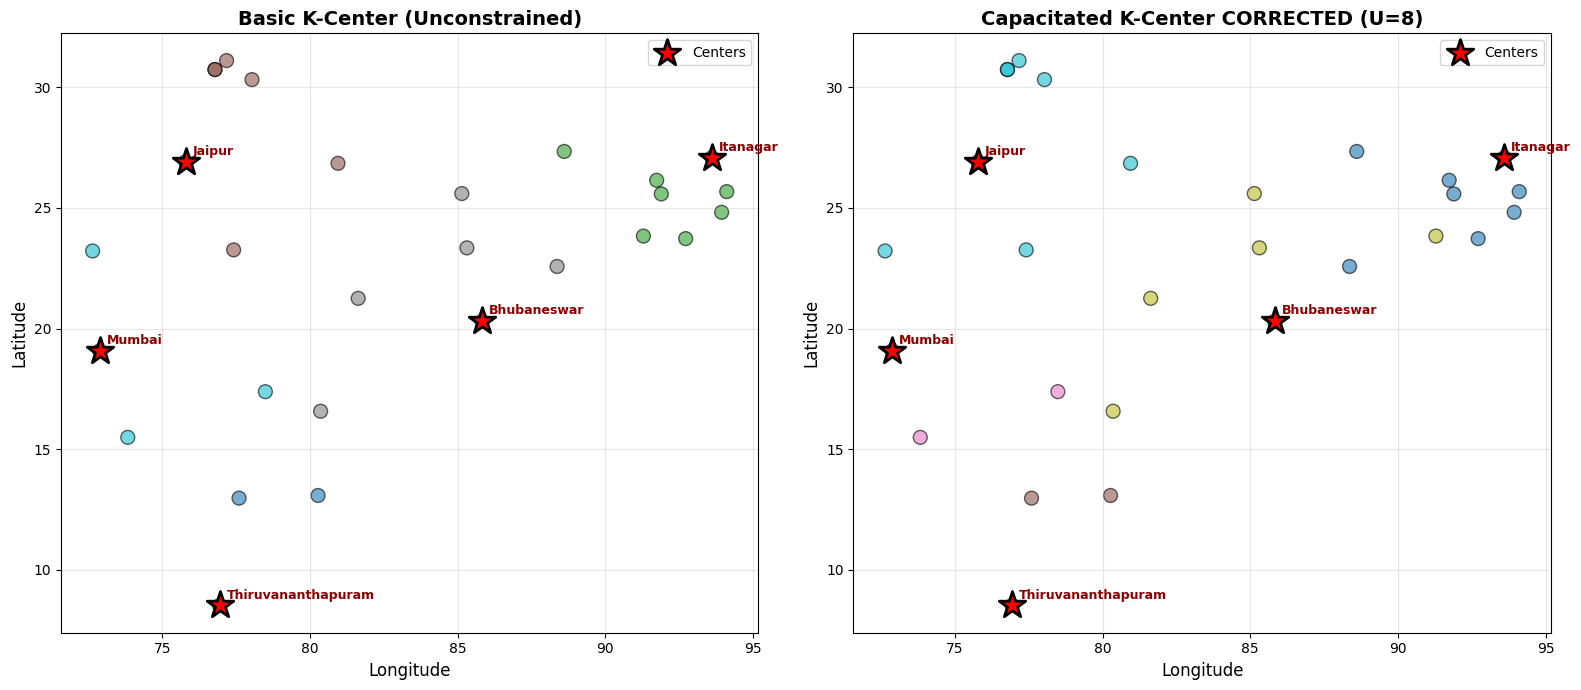


✓ Visualization complete


In [ ]:
if solution_corrected:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Plot 1: Basic K-Center
    ax1 = axes[0]
    basic_dist_matrix = compute_distance_matrix(C, basic_facilities)
    basic_labels = basic_dist_matrix.argmin(axis=1)

    scatter1 = ax1.scatter(C[:, 1], C[:, 0], c=basic_labels, cmap='tab10',
                          s=100, alpha=0.6, edgecolors='black', linewidth=1)
    ax1.scatter(basic_facilities[:, 1], basic_facilities[:, 0],
               c='red', s=400, marker='*', edgecolors='black', linewidth=2,
               label='Centers', zorder=5)

    ax1.set_title('Basic K-Center (Unconstrained)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Longitude', fontsize=12)
    ax1.set_ylabel('Latitude', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    for idx in basic_centers:
        city = df.iloc[idx]['Capital']
        ax1.annotate(city, (C[idx, 1], C[idx, 0]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold', color='darkred')

    # Plot 2: Capacitated (Corrected)
    ax2 = axes[1]
    cap_labels = np.zeros(n_clients)
    for c_idx, f_idx in solution_corrected['assignments'].items():
        cap_labels[c_idx] = f_idx

    scatter2 = ax2.scatter(C[:, 1], C[:, 0], c=cap_labels, cmap='tab10',
                          s=100, alpha=0.6, edgecolors='black', linewidth=1)

    used_facilities = solution_corrected['facilities']
    ax2.scatter(used_facilities[:, 1], used_facilities[:, 0],
               c='red', s=400, marker='*', edgecolors='black', linewidth=2,
               label='Centers', zorder=5)

    ax2.set_title(f'Capacitated K-Center CORRECTED (U={capacity})',
                 fontsize=14, fontweight='bold')
    ax2.set_xlabel('Longitude', fontsize=12)
    ax2.set_ylabel('Latitude', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    for f_idx in solution_corrected['facilities_indices']:
        city = df.iloc[f_idx]['Capital']
        ax2.annotate(city, (C[f_idx, 1], C[f_idx, 0]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold', color='darkred')

    plt.tight_layout()
    plt.show()

    print("\n✓ Visualization complete")